I. Outlier Treatment:

- Handling outliers of all the numerical values 

II. Feature Engineering:

`add new feature-`

- month number

- weekday number 

- Average shares by daily:

- Average shares by weekend:

- Average shares by data channel:

- title tokens
- 
text tokens

`analysiis -` 
- Long content and short content vs shares

- number of images vs shares - more images =more shares?



III. Feature Extraction:

- Wordcloud of the Description:
- POS features:

- Ngram features:

IV. Saving the final model ready data:

`22DS46`

# 1. Outlier treatment


**1.1 Importing libraries and using them**

In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

**1.2 Importing the dataset that we performed in EDA part**

In [2]:
df_features = pd.read_csv("data/news_share_data_selected.csv")
df_features.sample(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
720,another google glass wearer attacked san franc...,perils wearing google glass became apparent ye...,Sunday,0,April,Entertainment,1,0,0,0,...,9625.773,5628.886,1500.0,0.875000,-0.300000,0.010989,0.043956,0.6875,-0.375,2000
460,penny fabulous pig better wardrobe,forget presumptions pigs spiffy swine breaking...,Tuesday,0,April,Tech,0,0,0,0,...,4047.971,2733.259,3000.0,0.488799,0.198401,0.059123,0.018011,0.7000,0.625,2100
852,suspicious bags prompt evacuation boston marat...,tuesday one year anniversary deadly bombings l...,Tuesday,0,April,Business,0,0,0,0,...,3833.595,3555.526,1819.5,0.384316,0.162031,0.058824,0.006920,0.0000,0.000,905


In [3]:
df_features.shape

(999, 28)

In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               999 non-null    object 
 1   cleaned_text                999 non-null    object 
 2   weekday                     999 non-null    object 
 3   is_weekend                  999 non-null    int64  
 4   month                       999 non-null    object 
 5   cleaned_data_channel        999 non-null    object 
 6   Channel_Entertainment       999 non-null    int64  
 7   Channel_Lifestyle           999 non-null    int64  
 8   Channel_Others              999 non-null    int64  
 9   Channel_Social Media        999 non-null    int64  
 10  Channel_Tech                999 non-null    int64  
 11  unique_tokens_rate          999 non-null    float64
 12  num_hrefs                   999 non-null    int64  
 13  num_imgs                    999 non

In [5]:
df_features.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [6]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

In [7]:
print("\nDistribution (BEFORE outlier treatment):")
display(df_features[cols_to_treat].describe())


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.527192,11.706707,5.156156,1.219219,4.604425,7.207207,1132.205907,6427.349984,3355.117077,13554.811749,0.446645,0.106056,0.038137,0.017789,0.293408,0.057666,4245.291291
std,0.118711,15.177740,8.452842,4.087347,0.703038,1.859846,1181.656104,7345.282277,1456.857126,51598.155938,0.109343,0.092590,0.015668,0.010574,0.325482,0.267121,22652.511740
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.000000,-0.300000,0.000000,0.000000,0.000000,-1.000000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.867925,162.000000,84.000000,51.000000,7.218430,10.000000,3613.040000,102200.000000,17604.270000,663600.000000,0.875000,0.489623,0.120805,0.103030,1.000000,1.000000,663600.000000


In [8]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_features, col):
    q1 = df_features[col].quantile(0.25)
    q3 = df_features[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df_features[col] = df_features[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_features

for col in cols_to_treat:
    df_features = treat_outliers_iqr(df_features, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_features[cols_to_treat].describe())



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000


In [9]:
print(df_features[cols_to_treat].dtypes)


unique_tokens_rate            float64
num_hrefs                       int64
num_imgs                        int64
num_videos                    float64
average_token_length          float64
num_keywords                    int64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                          int64
dtype: object


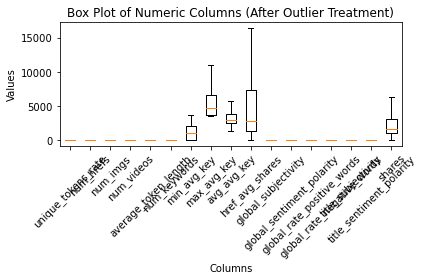

In [10]:
import matplotlib.pyplot as plt

plt.boxplot(df_features[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()


# 2. Feature Engineering

add new feature-

month number

weekday number

Average shares by daily:

Average shares by weekend:

Average shares by data channel:

title tokens

text tokens

analysiis -

Long content and short content vs shares

number of images vs shares - more images =more shares?

- Extracting out the month and day numbers

In [11]:
from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#df_features['month'] = encoder.fit_transform(df_features['month'])
#df_features[''] = encoder.fit_transform(df_features['weekday'])

month_label_mapping = {'March': 3, 'April': 4}
week_label_mapping = {'Friday': 0,'Saturday': 1,'Sunday': 2,'Monday': 3, 'Tuesday': 4, 'Wednesday': 5,'Thursday' : 6}

df_features['month no'] = df_features['month'].map(month_label_mapping)
df_features['weekday no'] = df_features['weekday'].map(week_label_mapping)



- Categorising all average shares 

In [12]:
df_features['avg shares daily'] = df_features.groupby('weekday')['shares'].transform('mean')
df_features['avg shares weekly'] = df_features.groupby('is_weekend')['shares'].transform('mean')
df_features['avg shares by channel'] = df_features.groupby('cleaned_data_channel')['shares'].transform('mean')


- Counting number of tokens for both title and text

In [13]:
from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

df_features['title_tokens'] = df_features['cleaned_title'].apply(count_tokens)
df_features['text_tokens'] = df_features['cleaned_text'].apply(count_tokens)

df_features[['cleaned_title', 'cleaned_text', 'title_tokens', 'text_tokens']]

,cleaned_title,cleaned_text,title_tokens,text_tokens
0,time youtube competitor,reported last week yahoo getting online video ...,3,102
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,8,54
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,8,239
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,5,141
4,google launch improved android camera app repo...,android users may soon see series new features...,8,148
...,...,...,...,...
994,make caesar salad 8 super specific apps,lets cut chase apps lot bells whistles theres ...,7,47
995,taylor swift surprised fan bridal shower,taylor swift bridal showers made pastels baked...,6,133
996,amazing spiderman 2 hosts first google hangout...,weve seen big movies throw big google hangouts...,10,84
997,2 animators independently recreated pixar magic,pixar art directors robert kondo dice tsutsumi...,6,445


In [14]:
df_features.sample(4)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,title_subjectivity,title_sentiment_polarity,shares,month no,weekday no,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens
57,mark calendar spring meteor showers eclipses,eclipses planets meteor showers galore norther...,Tuesday,0,April,Business,0,0,0,0,...,0.5,0.375,6250,4,4,2233.879630,2316.046429,2312.036810,6,612
895,brands follow instagram watching verrrry closely,brands follow instagram may paying close atten...,Wednesday,0,April,Others,0,0,1,0,...,0.0,0.000,1500,4,5,2157.572687,2316.046429,2208.388571,6,314
306,thing hipsters love beer coffee,things world hipsters love microbrews obscure ...,Saturday,1,April,Lifestyle,0,1,0,0,...,0.0,0.000,1100,4,1,3088.297872,2634.698113,2467.280000,5,61
523,protect heartbleed bug,encryption flaw called heartbleed bug exposed ...,Wednesday,0,April,Others,0,0,1,0,...,0.0,0.000,3400,4,5,2157.572687,2316.046429,2208.388571,3,374


- Long content and short content vs shares

- number of images vs shares - more images =more shares?

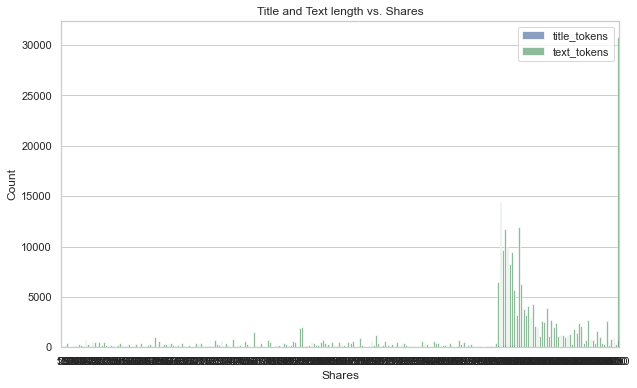

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by 'shares' and count occurrences of 'title_tokens' and 'text_tokens'
grouped_data = df_features.groupby('shares')[['title_tokens', 'text_tokens']].sum()

# Create a stacked bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use the 'hue' parameter to create a stacked bar chart
sns.barplot(data=grouped_data.reset_index(), x='shares', y='title_tokens', color='b', label='title_tokens', alpha=0.7)
sns.barplot(data=grouped_data.reset_index(), x='shares', y='text_tokens', color='g', label='text_tokens', alpha=0.7)

plt.xlabel('Shares')
plt.ylabel('Count')
plt.title('Title and Text length vs. Shares')
plt.legend(loc='upper right')
plt.show()
